In [2]:
%pip install ultralytics cleverhans torchattacks scikit-learn seaborn
!pip install git+https://github.com/fra31/auto-attack

  Cloning https://github.com/fra31/auto-attack to /tmp/pip-req-build-lom80wab
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack /tmp/pip-req-build-lom80wab
  Resolved https://github.com/fra31/auto-attack to commit a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Preparing metadata (setup.py) ... done
  Created wheel for autoattack: filename=autoattack-0.1-py3-none-any.whl size=36228 sha256=9a9cb08cce2b1dacff48037359e151b8550060f550fb87f7c84b2274e5ca38a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-0f0u1adq/wheels/e1/e8/28/65b2724d4c7740785979eb50bf5e1b3986ead22f6c32a87f8f
Successfully built autoattack


In [2]:
"""Module to train and save model with clean or adversarial examples"""

from easydict import EasyDict
from ultralytics import YOLO
from ultralytics.models.yolo.model import ClassificationModel
import numpy as np
import torch
import torch.nn as nn
import torchvision
from google.colab import files

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)


class YOLOClassifierWrapper(nn.Module):
    def __init__(self, yolov8_model):
        super().__init__()
        self.model = yolov8_model

    def forward(self, x):
        out = self.model(x)
        if isinstance(out, tuple):
            out = out[0]  # Extract logits if it's a tuple
        return out


class Flags:
    nb_epochs = 200
    eps = 0.3
    adv_train = False
    train_mode = "mixed"


FLAGS = Flags

train_transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()]
)
test_transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()]
)
train_dataset = torchvision.datasets.CIFAR100(
    root="/tmp/data", train=True, transform=train_transforms, download=True
)
test_dataset = torchvision.datasets.CIFAR100(
    root="/tmp/data", train=False, transform=test_transforms, download=True
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2
)

data = EasyDict(train=train_loader, test=test_loader)

# Use GPU
device = "cuda"

# Load the YOLOv8 classification model
model = YOLO("yolov8x-cls.pt")
internal_model = model.model
ClassificationModel.reshape_outputs(internal_model, 100)

# Wrap in helper class
net = YOLOClassifierWrapper(internal_model)

model_output_name = "-yolov8-cls-clean-trained.pt"

if FLAGS.train_mode == "mixed":
  net = torch.load("/content/models/200-yolov8-cls-adv-trained.pt")
  model_output_name = "-yolov8-cls-mixed-trained.pt"

# Default to clean, non-defensive configuration
loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

if FLAGS.adv_train:
  # Change to model with adv. training and other defensive configurations
  loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)
  model_output_name = "-yolov8-cls-adv-trained.pt"

# Send to device and set model to training mode
net.to(device).float()
net.train()

for epoch in range(1, FLAGS.nb_epochs + 1):
    train_loss = 0.0
    for x, y in data.train:
        x, y = x.to(device), y.to(device)
        if FLAGS.adv_train:
            # Replace clean example with adversarial example for adversarial training
            x = projected_gradient_descent(net, x, FLAGS.eps, 0.01, 40, np.inf)
        optimizer.zero_grad()
        loss = loss_fn(net(x), y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(
        "epoch: {}/{}, train loss: {:.3f}".format(
            epoch, FLAGS.nb_epochs, train_loss
        )
    )
    print("Saving checkpoint... ")
    torch.save({
        'epoch': epoch,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, "checkpoint" + model_output_name)

# Save model resulting from training

torch.save(net, str(FLAGS.nb_epochs) + model_output_name)
files.download(str(FLAGS.nb_epochs) + model_output_name)


KeyboardInterrupt: 

In [3]:
!mkdir -p models
# YOLOv8 model trained with only adversarial examples
!curl -L -o models/200-yolov8x-cls-adv-trained.tar.gz https://www.kaggle.com/api/v1/models/jeffcolf/200-yolov8x-cls-adv-cifar/pyTorch/default/1/download
!file models/200-yolov8x-cls-adv-trained.tar.gz
!tar -xf models/200-yolov8x-cls-adv-trained.tar.gz -C models

# YOLOv8 model trained with only clean examples
!curl -L -o models/400-yolov8x-cls-clean-trained.tar.gz https://www.kaggle.com/api/v1/models/jeffcolf/400-yolo-cls-clean-cifar/pyTorch/default/1/download
!file models/400-yolov8x-cls-clean-trained.tar.gz
!tar -xf models/400-yolov8x-cls-clean-trained.tar.gz -C models

# YOLOv8 model trained with both clean and adversarial examples
!curl -L -o models/400-yolov8x-cls-mixed-trained.tar.gz https://www.kaggle.com/api/v1/models/jeffcolf/400-yolov8x-cls-mixed-cifar/pyTorch/default/1/download
!file models/400-yolov8x-cls-mixed-trained.tar.gz
!tar -xf models/400-yolov8x-cls-mixed-trained.tar.gz -C models

# Change names for easier access
!mv /content/models/200-yolov8-cls-adv-trained.pt /content/models/adv-trained.pt
!mv /content/models/200-yolov8-cls-mixed-trained.pt /content/models/mixed-trained.pt
!mv /content/models/400-yolov8-cls-clean-trained.pt /content/models/clean-trained.pt

# Clean up
!rm /content/models/200-yolov8x-cls-adv-trained.tar.gz
!rm /content/models/400-yolov8x-cls-clean-trained.tar.gz
!rm /content/models/400-yolov8x-cls-mixed-trained.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  128M  100  128M    0     0  12.6M      0  0:00:10  0:00:10 --:--:-- 19.3M
models/200-yolov8x-cls-adv-trained.tar.gz: gzip compressed data, last modified: Thu May  8 15:54:41 2025, original size modulo 2^32 225402880
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  128M  100  128M    0     0  14.9M      0  0:00:08  0:00:08 --:--:-- 21.2M
models/400-yolov8x-cls-clean-trained.tar.gz: gzip compressed data, last modified: Thu May  8 16:47:20 2025, original size modulo 2^32 225402880
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
  


Evaluating Clean-Trained without inference-time defenses


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for FGM


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for PGD


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for Spatial


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for Square
Clean-Trained without defenses accuracy on clean examples: 23.63%
Clean-Trained without defenses accuracy on FGM: 1.04%
Clean-Trained without defenses accuracy on PGD: 1.37%
Clean-Trained without defenses accuracy on Spatial: 17.32%
Clean-Trained without defenses accuracy on Square: 0.00%

===== Evaluation: Clean-Trained without defenses - Clean =====
              precision    recall  f1-score   support

           0     0.5038    0.6600    0.5714       100
           1     0.2133    0.1600    0.1829       100
           2     0.1757    0.1300    0.1494       100
           3     0.1216    0.0900    0.1034       100
           4     0.0909    0.0600    0.0723       100
           5     0.1667    0.1100    0.1325       100
           6     0.2750    0.1100    0.1571       100
           7     0.2500    0.2400    0.2449       100
           8     0.2263    0.3100    0.2616       100
           9     0.3679    0.3900    0.3786       100
        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.6143

===== Evaluation: Clean-Trained without defenses - FGM =====
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.0000    0.0000    0.0000       100
           4     0.0000    0.0000    0.0000       100
           5     0.0000    0.0000    0.0000       100
           6     0.0000    0.0000    0.0000       100
           7     0.0000    0.0000    0.0000       100
           8     0.0000    0.0000    0.0000       100
           9     0.0199    0.0400    0.0266       100
          10     0.2000    0.0400    0.0667       100
          11     0.0000    0.0000    0.0000       100
          12     0.0000    0.0000    0.0000       100
          13     0.0000    0.0000    0.0000       100
          14     0.0000    0.0000    0.0000       100
          15     0.0000    0.0000    0.0000 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5002

===== Evaluation: Clean-Trained without defenses - PGD =====
              precision    recall  f1-score   support

           0     0.0714    0.0200    0.0312       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.0000    0.0000    0.0000       100
           4     0.0000    0.0000    0.0000       100
           5     0.0000    0.0000    0.0000       100
           6     0.0000    0.0000    0.0000       100
           7     0.0000    0.0000    0.0000       100
           8     0.0448    0.0300    0.0359       100
           9     0.0242    0.0400    0.0302       100
          10     0.0455    0.0300    0.0361       100
          11     0.0000    0.0000    0.0000       100
          12     0.0103    0.0100    0.0102       100
          13     0.0000    0.0000    0.0000       100
          14     0.0294    0.0200    0.0238       100
          15     0.0000    0.0000    0.0000 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5019

===== Evaluation: Clean-Trained without defenses - Spatial =====
              precision    recall  f1-score   support

           0     0.5283    0.5600    0.5437       100
           1     0.1321    0.0700    0.0915       100
           2     0.1646    0.1300    0.1453       100
           3     0.1408    0.1000    0.1170       100
           4     0.0260    0.0200    0.0226       100
           5     0.1364    0.0600    0.0833       100
           6     0.0816    0.0400    0.0537       100
           7     0.1797    0.2300    0.2018       100
           8     0.1449    0.2000    0.1681       100
           9     0.2750    0.3300    0.3000       100
          10     0.2812    0.1800    0.2195       100
          11     0.1667    0.1000    0.1250       100
          12     0.1573    0.1400    0.1481       100
          13     0.0426    0.0200    0.0272       100
          14     0.1474    0.1400    0.1436       100
          15     0.1167    0.0700    0.0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5824

===== Evaluation: Clean-Trained without defenses - Square =====
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     100.0
           1     0.0000    0.0000    0.0000     100.0
           2     0.0000    0.0000    0.0000     100.0
           3     0.0000    0.0000    0.0000     100.0
           4     0.0000    0.0000    0.0000     100.0
           5     0.0000    0.0000    0.0000     100.0
           6     0.0000    0.0000    0.0000     100.0
           7     0.0000    0.0000    0.0000     100.0
           8     0.0000    0.0000    0.0000     100.0
           9     0.0000    0.0000    0.0000     100.0
          10     0.0000    0.0000    0.0000     100.0
          11     0.0000    0.0000    0.0000     100.0
          12     0.0000    0.0000    0.0000     100.0
          13     0.0000    0.0000    0.0000     100.0
          14     0.0000    0.0000    0.0000     100.0
          15     0.0000    0.0000    0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.4949

Evaluating Clean-Trained with inference-time defenses


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for FGM


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for PGD


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for Spatial


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for Square
Clean-Trained with defenses accuracy on clean examples: 16.32%
Clean-Trained with defenses accuracy on FGM: 1.14%
Clean-Trained with defenses accuracy on PGD: 1.12%
Clean-Trained with defenses accuracy on Spatial: 11.60%
Clean-Trained with defenses accuracy on Square: 0.01%

===== Evaluation: Clean-Trained with defenses - Clean =====
              precision    recall  f1-score   support

           0     0.5750    0.4600    0.5111       100
           1     0.1786    0.1000    0.1282       100
           2     0.1200    0.0300    0.0480       100
           3     0.0351    0.0200    0.0255       100
           4     0.0667    0.0500    0.0571       100
           5     0.1695    0.1000    0.1258       100
           6     0.1481    0.0400    0.0630       100
           7     0.1173    0.1900    0.1450       100
           8     0.1597    0.1900    0.1735       100
           9     0.2571    0.2700    0.2634       100
          10     0.1724   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5774

===== Evaluation: Clean-Trained with defenses - FGM =====
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.0000    0.0000    0.0000       100
           4     1.0000    0.0100    0.0198       100
           5     0.0000    0.0000    0.0000       100
           6     0.0000    0.0000    0.0000       100
           7     0.1000    0.0100    0.0182       100
           8     0.0000    0.0000    0.0000       100
           9     0.0213    0.0400    0.0278       100
          10     0.0476    0.0100    0.0165       100
          11     0.0000    0.0000    0.0000       100
          12     0.0000    0.0000    0.0000       100
          13     0.0000    0.0000    0.0000       100
          14     0.0000    0.0000    0.0000       100
          15     0.0000    0.0000    0.0000    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5007

===== Evaluation: Clean-Trained with defenses - PGD =====
              precision    recall  f1-score   support

           0     0.0377    0.0200    0.0261       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.0000    0.0000    0.0000       100
           4     0.0000    0.0000    0.0000       100
           5     0.0000    0.0000    0.0000       100
           6     0.0471    0.0400    0.0432       100
           7     0.0000    0.0000    0.0000       100
           8     0.0417    0.0300    0.0349       100
           9     0.0134    0.0200    0.0161       100
          10     0.0222    0.0200    0.0211       100
          11     0.3333    0.0100    0.0194       100
          12     0.0143    0.0100    0.0118       100
          13     0.0000    0.0000    0.0000       100
          14     0.0000    0.0000    0.0000       100
          15     0.0000    0.0000    0.0000    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5006

===== Evaluation: Clean-Trained with defenses - Spatial =====
              precision    recall  f1-score   support

           0     0.5385    0.4200    0.4719       100
           1     0.1765    0.0900    0.1192       100
           2     0.0000    0.0000    0.0000       100
           3     0.0536    0.0300    0.0385       100
           4     0.0282    0.0200    0.0234       100
           5     0.1250    0.0400    0.0606       100
           6     0.1053    0.0400    0.0580       100
           7     0.0727    0.1200    0.0906       100
           8     0.0864    0.0700    0.0773       100
           9     0.1957    0.1800    0.1875       100
          10     0.1957    0.0900    0.1233       100
          11     0.1379    0.0400    0.0620       100
          12     0.0667    0.0500    0.0571       100
          13     0.1500    0.0300    0.0500       100
          14     0.1714    0.1200    0.1412       100
          15     0.0526    0.0300    0.0382

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5535

===== Evaluation: Clean-Trained with defenses - Square =====
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.0000    0.0000    0.0000       100
           4     0.0000    0.0000    0.0000       100
           5     0.0000    0.0000    0.0000       100
           6     0.0000    0.0000    0.0000       100
           7     0.0000    0.0000    0.0000       100
           8     0.0000    0.0000    0.0000       100
           9     0.0000    0.0000    0.0000       100
          10     0.0000    0.0000    0.0000       100
          11     0.0000    0.0000    0.0000       100
          12     0.0000    0.0000    0.0000       100
          13     0.0000    0.0000    0.0000       100
          14     0.0000    0.0000    0.0000       100
          15     0.0000    0.0000    0.0000 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.4950

Evaluating Adv-Trained without inference-time defenses


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for FGM


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for PGD


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for Spatial


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for Square
Adv-Trained without defenses accuracy on clean examples: 1.82%
Adv-Trained without defenses accuracy on FGM: 3.21%
Adv-Trained without defenses accuracy on PGD: 4.87%
Adv-Trained without defenses accuracy on Spatial: 1.93%
Adv-Trained without defenses accuracy on Square: 0.00%

===== Evaluation: Adv-Trained without defenses - Clean =====
              precision    recall  f1-score   support

           0     0.0094    0.0700    0.0165       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.0000    0.0000    0.0000       100
           4     0.0000    0.0000    0.0000       100
           5     0.0000    0.0000    0.0000       100
           6     0.0000    0.0000    0.0000       100
           7     0.0000    0.0000    0.0000       100
           8     0.0000    0.0000    0.0000       100
           9     0.0000    0.0000    0.0000       100
          10     0.032

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5041

===== Evaluation: Adv-Trained without defenses - FGM =====
              precision    recall  f1-score   support

           0     0.0345    0.0100    0.0155       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.1250    0.0100    0.0185       100
           4     0.0000    0.0000    0.0000       100
           5     0.0000    0.0000    0.0000       100
           6     0.0000    0.0000    0.0000       100
           7     0.0000    0.0000    0.0000       100
           8     0.0217    0.0200    0.0208       100
           9     0.0645    0.0200    0.0305       100
          10     0.0333    0.0200    0.0250       100
          11     0.0000    0.0000    0.0000       100
          12     0.0000    0.0000    0.0000       100
          13     0.0000    0.0000    0.0000       100
          14     0.0000    0.0000    0.0000       100
          15     0.0132    0.0100    0.0114   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5112

===== Evaluation: Adv-Trained without defenses - PGD =====
              precision    recall  f1-score   support

           0     0.3889    0.0700    0.1186       100
           1     0.0686    0.0700    0.0693       100
           2     0.0074    0.0100    0.0085       100
           3     0.0337    0.0300    0.0317       100
           4     0.0256    0.0200    0.0225       100
           5     0.0000    0.0000    0.0000       100
           6     0.0000    0.0000    0.0000       100
           7     0.0375    0.0300    0.0333       100
           8     0.0000    0.0000    0.0000       100
           9     0.0612    0.1500    0.0870       100
          10     0.0139    0.0100    0.0116       100
          11     0.0000    0.0000    0.0000       100
          12     0.0870    0.0200    0.0325       100
          13     0.1176    0.0200    0.0342       100
          14     0.0000    0.0000    0.0000       100
          15     0.0408    0.0200    0.0268   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5195

===== Evaluation: Adv-Trained without defenses - Spatial =====
              precision    recall  f1-score   support

           0     0.0116    0.0900    0.0206       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.0000    0.0000    0.0000       100
           4     0.0000    0.0000    0.0000       100
           5     0.0000    0.0000    0.0000       100
           6     0.0000    0.0000    0.0000       100
           7     0.0000    0.0000    0.0000       100
           8     0.0000    0.0000    0.0000       100
           9     0.0000    0.0000    0.0000       100
          10     0.1176    0.0200    0.0342       100
          11     0.0000    0.0000    0.0000       100
          12     0.0000    0.0000    0.0000       100
          13     0.0000    0.0000    0.0000       100
          14     0.0000    0.0000    0.0000       100
          15     0.2500    0.0100    0.019

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5047

===== Evaluation: Adv-Trained without defenses - Square =====
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     100.0
           1     0.0000    0.0000    0.0000     100.0
           2     0.0000    0.0000    0.0000     100.0
           3     0.0000    0.0000    0.0000     100.0
           4     0.0000    0.0000    0.0000     100.0
           5     0.0000    0.0000    0.0000     100.0
           6     0.0000    0.0000    0.0000     100.0
           7     0.0000    0.0000    0.0000     100.0
           8     0.0000    0.0000    0.0000     100.0
           9     0.0000    0.0000    0.0000     100.0
          10     0.0000    0.0000    0.0000     100.0
          11     0.0000    0.0000    0.0000     100.0
          12     0.0000    0.0000    0.0000     100.0
          13     0.0000    0.0000    0.0000     100.0
          14     0.0000    0.0000    0.0000     100.0
          15     0.0000    0.0000    0.0000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.4949

Evaluating Adv-Trained with inference-time defenses


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for FGM


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for PGD


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for Spatial


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for Square
Adv-Trained with defenses accuracy on clean examples: 2.20%
Adv-Trained with defenses accuracy on FGM: 3.36%
Adv-Trained with defenses accuracy on PGD: 4.46%
Adv-Trained with defenses accuracy on Spatial: 2.21%
Adv-Trained with defenses accuracy on Square: 0.00%

===== Evaluation: Adv-Trained with defenses - Clean =====
              precision    recall  f1-score   support

           0     0.0173    0.1200    0.0303       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.0000    0.0000    0.0000       100
           4     0.0000    0.0000    0.0000       100
           5     0.1429    0.0100    0.0187       100
           6     0.0000    0.0000    0.0000       100
           7     0.0000    0.0000    0.0000       100
           8     0.0000    0.0000    0.0000       100
           9     0.0000    0.0000    0.0000       100
          10     0.0000    0.0000    0.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5061

===== Evaluation: Adv-Trained with defenses - FGM =====
              precision    recall  f1-score   support

           0     0.1515    0.0500    0.0752       100
           1     0.0714    0.0100    0.0175       100
           2     0.0000    0.0000    0.0000       100
           3     0.0833    0.0100    0.0179       100
           4     0.0000    0.0000    0.0000       100
           5     0.0000    0.0000    0.0000       100
           6     0.0000    0.0000    0.0000       100
           7     0.2500    0.0200    0.0370       100
           8     0.0171    0.0200    0.0184       100
           9     0.0909    0.0400    0.0556       100
          10     0.0267    0.0200    0.0229       100
          11     0.0000    0.0000    0.0000       100
          12     0.0000    0.0000    0.0000       100
          13     0.0000    0.0000    0.0000       100
          14     0.0000    0.0000    0.0000       100
          15     0.0130    0.0100    0.0113      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5119

===== Evaluation: Adv-Trained with defenses - PGD =====
              precision    recall  f1-score   support

           0     0.2500    0.0600    0.0968       100
           1     0.0921    0.0700    0.0795       100
           2     0.0000    0.0000    0.0000       100
           3     0.0154    0.0100    0.0121       100
           4     0.0337    0.0300    0.0317       100
           5     0.0192    0.0100    0.0132       100
           6     0.0000    0.0000    0.0000       100
           7     0.0323    0.0200    0.0247       100
           8     0.0000    0.0000    0.0000       100
           9     0.0505    0.1400    0.0743       100
          10     0.0149    0.0100    0.0120       100
          11     0.0270    0.0100    0.0146       100
          12     0.0417    0.0100    0.0161       100
          13     0.0000    0.0000    0.0000       100
          14     0.0000    0.0000    0.0000       100
          15     0.0615    0.0400    0.0485      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5175

===== Evaluation: Adv-Trained with defenses - Spatial =====
              precision    recall  f1-score   support

           0     0.0110    0.0800    0.0194       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.0000    0.0000    0.0000       100
           4     0.0000    0.0000    0.0000       100
           5     0.0714    0.0100    0.0175       100
           6     0.0000    0.0000    0.0000       100
           7     0.1667    0.0100    0.0189       100
           8     0.0000    0.0000    0.0000       100
           9     0.0444    0.0200    0.0276       100
          10     0.0000    0.0000    0.0000       100
          11     0.0000    0.0000    0.0000       100
          12     0.0556    0.0100    0.0169       100
          13     0.0000    0.0000    0.0000       100
          14     0.0000    0.0000    0.0000       100
          15     0.0000    0.0000    0.0000  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5061

===== Evaluation: Adv-Trained with defenses - Square =====
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     100.0
           1     0.0000    0.0000    0.0000     100.0
           2     0.0000    0.0000    0.0000     100.0
           3     0.0000    0.0000    0.0000     100.0
           4     0.0000    0.0000    0.0000     100.0
           5     0.0000    0.0000    0.0000     100.0
           6     0.0000    0.0000    0.0000     100.0
           7     0.0000    0.0000    0.0000     100.0
           8     0.0000    0.0000    0.0000     100.0
           9     0.0000    0.0000    0.0000     100.0
          10     0.0000    0.0000    0.0000     100.0
          11     0.0000    0.0000    0.0000     100.0
          12     0.0000    0.0000    0.0000     100.0
          13     0.0000    0.0000    0.0000     100.0
          14     0.0000    0.0000    0.0000     100.0
          15     0.0000    0.0000    0.0000   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.4949

Evaluating Mixed-Trained without inference-time defenses


<ipython-input-5-4a2ec195ae8c>:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(num_images * 2, (len(attack_names) + 1) * 2))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for FGM


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for PGD


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for Spatial


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for Square
Mixed-Trained without defenses accuracy on clean examples: 23.92%
Mixed-Trained without defenses accuracy on FGM: 0.98%
Mixed-Trained without defenses accuracy on PGD: 1.16%
Mixed-Trained without defenses accuracy on Spatial: 18.24%
Mixed-Trained without defenses accuracy on Square: 0.00%

===== Evaluation: Mixed-Trained without defenses - Clean =====
              precision    recall  f1-score   support

           0     0.5000    0.5600    0.5283       100
           1     0.2105    0.1600    0.1818       100
           2     0.1321    0.0700    0.0915       100
           3     0.1124    0.1000    0.1058       100
           4     0.1047    0.0900    0.0968       100
           5     0.1849    0.2200    0.2009       100
           6     0.2319    0.1600    0.1893       100
           7     0.3231    0.2100    0.2545       100
           8     0.3000    0.3300    0.3143       100
           9     0.3545    0.3900    0.3714       100
        

<ipython-input-5-4a2ec195ae8c>:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC (macro, OVR): 0.6158

===== Evaluation: Mixed-Trained without defenses - FGM =====
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.0000    0.0000    0.0000       100
           4     0.0000    0.0000    0.0000       100
           5     0.0000    0.0000    0.0000       100
           6     0.0000    0.0000    0.0000       100
           7     0.0000    0.0000    0.0000       100
           8     0.0000    0.0000    0.0000       100
           9     0.0323    0.0200    0.0247       100
          10     0.0312    0.0100    0.0152       100
          11     0.0000    0.0000    0.0000       100
          12     0.0000    0.0000    0.0000       100
          13     0.0000    0.0000    0.0000       100
          14     0.0000    0.0000    0.0000       100
          15     0.0000    0.0000    0.0000 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.4999

===== Evaluation: Mixed-Trained without defenses - PGD =====
              precision    recall  f1-score   support

           0     0.1071    0.0300    0.0469       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.1000    0.0100    0.0182       100
           4     0.0357    0.0100    0.0156       100
           5     0.0000    0.0000    0.0000       100
           6     0.0294    0.0100    0.0149       100
           7     0.0000    0.0000    0.0000       100
           8     0.0606    0.0200    0.0301       100
           9     0.0430    0.0400    0.0415       100
          10     0.0310    0.0400    0.0349       100
          11     0.0000    0.0000    0.0000       100
          12     0.0286    0.0200    0.0235       100
          13     0.0000    0.0000    0.0000       100
          14     0.0303    0.0200    0.0241       100
          15     0.0000    0.0000    0.0000 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5008

===== Evaluation: Mixed-Trained without defenses - Spatial =====
              precision    recall  f1-score   support

           0     0.6629    0.5900    0.6243       100
           1     0.2105    0.1200    0.1529       100
           2     0.1071    0.0600    0.0769       100
           3     0.1111    0.1200    0.1154       100
           4     0.0563    0.0400    0.0468       100
           5     0.1268    0.0900    0.1053       100
           6     0.1143    0.0800    0.0941       100
           7     0.2019    0.2100    0.2059       100
           8     0.2051    0.2400    0.2212       100
           9     0.2754    0.1900    0.2249       100
          10     0.1948    0.1500    0.1695       100
          11     0.1023    0.0900    0.0957       100
          12     0.1818    0.1200    0.1446       100
          13     0.1842    0.0700    0.1014       100
          14     0.1556    0.1400    0.1474       100
          15     0.1250    0.1200    0.1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5871

===== Evaluation: Mixed-Trained without defenses - Square =====
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     100.0
           1     0.0000    0.0000    0.0000     100.0
           2     0.0000    0.0000    0.0000     100.0
           3     0.0000    0.0000    0.0000     100.0
           4     0.0000    0.0000    0.0000     100.0
           5     0.0000    0.0000    0.0000     100.0
           6     0.0000    0.0000    0.0000     100.0
           7     0.0000    0.0000    0.0000     100.0
           8     0.0000    0.0000    0.0000     100.0
           9     0.0000    0.0000    0.0000     100.0
          10     0.0000    0.0000    0.0000     100.0
          11     0.0000    0.0000    0.0000     100.0
          12     0.0000    0.0000    0.0000     100.0
          13     0.0000    0.0000    0.0000     100.0
          14     0.0000    0.0000    0.0000     100.0
          15     0.0000    0.0000    0.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.4949

Evaluating Mixed-Trained with inference-time defenses


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for FGM


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for PGD


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for Spatial


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved successful attack example for Square
Mixed-Trained with defenses accuracy on clean examples: 15.98%
Mixed-Trained with defenses accuracy on FGM: 0.93%
Mixed-Trained with defenses accuracy on PGD: 1.26%
Mixed-Trained with defenses accuracy on Spatial: 11.88%
Mixed-Trained with defenses accuracy on Square: 0.00%

===== Evaluation: Mixed-Trained with defenses - Clean =====
              precision    recall  f1-score   support

           0     0.6087    0.4200    0.4970       100
           1     0.1860    0.0800    0.1119       100
           2     0.2143    0.0600    0.0938       100
           3     0.0349    0.0300    0.0323       100
           4     0.0723    0.0600    0.0656       100
           5     0.1364    0.1500    0.1429       100
           6     0.1026    0.0400    0.0576       100
           7     0.1579    0.1800    0.1682       100
           8     0.2025    0.1600    0.1788       100
           9     0.2604    0.2500    0.2551       100
          10     0.1833   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5757

===== Evaluation: Mixed-Trained with defenses - FGM =====
              precision    recall  f1-score   support

           0     0.0099    0.0100    0.0100       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.0000    0.0000    0.0000       100
           4     0.0000    0.0000    0.0000       100
           5     0.0000    0.0000    0.0000       100
           6     0.0000    0.0000    0.0000       100
           7     0.0000    0.0000    0.0000       100
           8     0.0000    0.0000    0.0000       100
           9     0.0152    0.0100    0.0120       100
          10     0.0000    0.0000    0.0000       100
          11     0.0000    0.0000    0.0000       100
          12     0.0000    0.0000    0.0000       100
          13     0.0000    0.0000    0.0000       100
          14     0.0000    0.0000    0.0000       100
          15     0.0000    0.0000    0.0000    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.4996

===== Evaluation: Mixed-Trained with defenses - PGD =====
              precision    recall  f1-score   support

           0     0.0286    0.0100    0.0148       100
           1     0.0000    0.0000    0.0000       100
           2     0.0000    0.0000    0.0000       100
           3     0.0000    0.0000    0.0000       100
           4     0.0000    0.0000    0.0000       100
           5     0.0000    0.0000    0.0000       100
           6     0.0227    0.0100    0.0139       100
           7     0.0222    0.0100    0.0138       100
           8     0.0345    0.0100    0.0155       100
           9     0.0256    0.0300    0.0276       100
          10     0.0561    0.0600    0.0580       100
          11     0.0000    0.0000    0.0000       100
          12     0.0167    0.0100    0.0125       100
          13     0.0000    0.0000    0.0000       100
          14     0.0282    0.0200    0.0234       100
          15     0.0000    0.0000    0.0000    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5013

===== Evaluation: Mixed-Trained with defenses - Spatial =====
              precision    recall  f1-score   support

           0     0.5588    0.3800    0.4524       100
           1     0.2857    0.1400    0.1879       100
           2     0.1200    0.0300    0.0480       100
           3     0.0732    0.0600    0.0659       100
           4     0.0000    0.0000    0.0000       100
           5     0.1176    0.0600    0.0795       100
           6     0.0536    0.0300    0.0385       100
           7     0.1193    0.1300    0.1244       100
           8     0.1406    0.0900    0.1098       100
           9     0.1282    0.1000    0.1124       100
          10     0.1905    0.0800    0.1127       100
          11     0.0488    0.0200    0.0284       100
          12     0.2500    0.1200    0.1622       100
          13     0.1765    0.0300    0.0513       100
          14     0.1622    0.1200    0.1379       100
          15     0.0811    0.0600    0.0690

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.5549

===== Evaluation: Mixed-Trained with defenses - Square =====
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     100.0
           1     0.0000    0.0000    0.0000     100.0
           2     0.0000    0.0000    0.0000     100.0
           3     0.0000    0.0000    0.0000     100.0
           4     0.0000    0.0000    0.0000     100.0
           5     0.0000    0.0000    0.0000     100.0
           6     0.0000    0.0000    0.0000     100.0
           7     0.0000    0.0000    0.0000     100.0
           8     0.0000    0.0000    0.0000     100.0
           9     0.0000    0.0000    0.0000     100.0
          10     0.0000    0.0000    0.0000     100.0
          11     0.0000    0.0000    0.0000     100.0
          12     0.0000    0.0000    0.0000     100.0
          13     0.0000    0.0000    0.0000     100.0
          14     0.0000    0.0000    0.0000     100.0
          15     0.0000    0.0000    0.0000 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC-ROC (macro, OVR): 0.4949


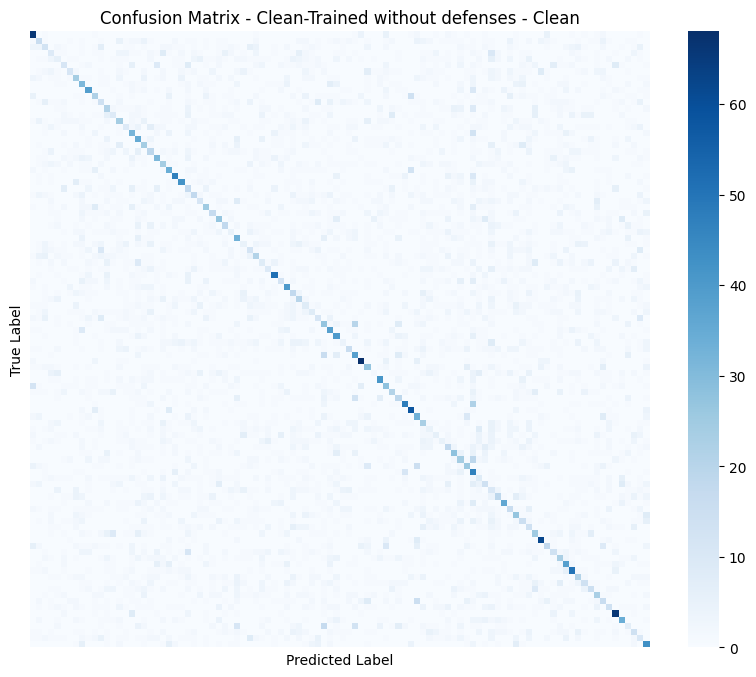

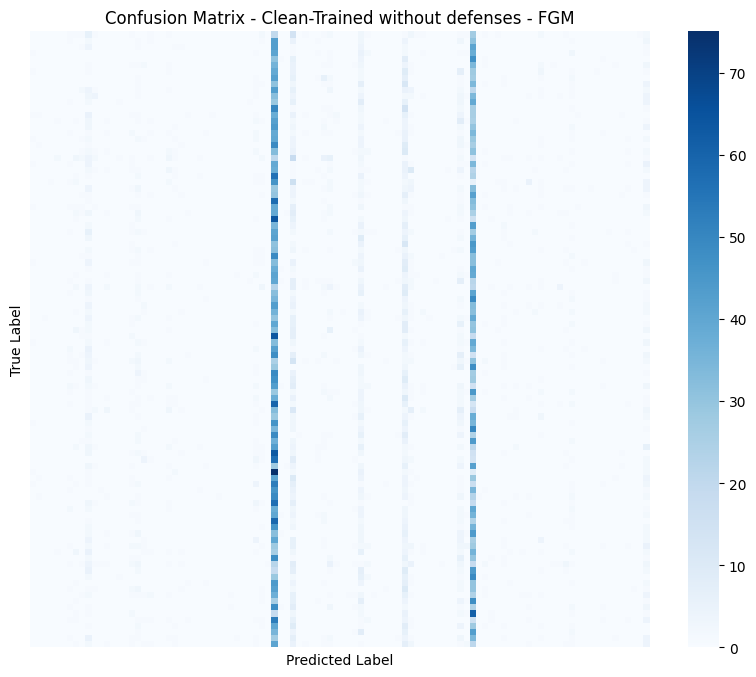

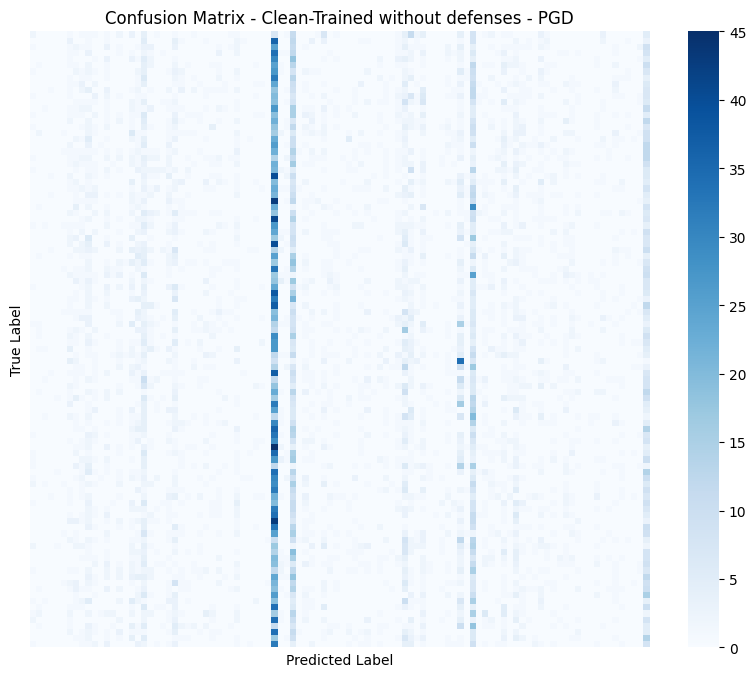

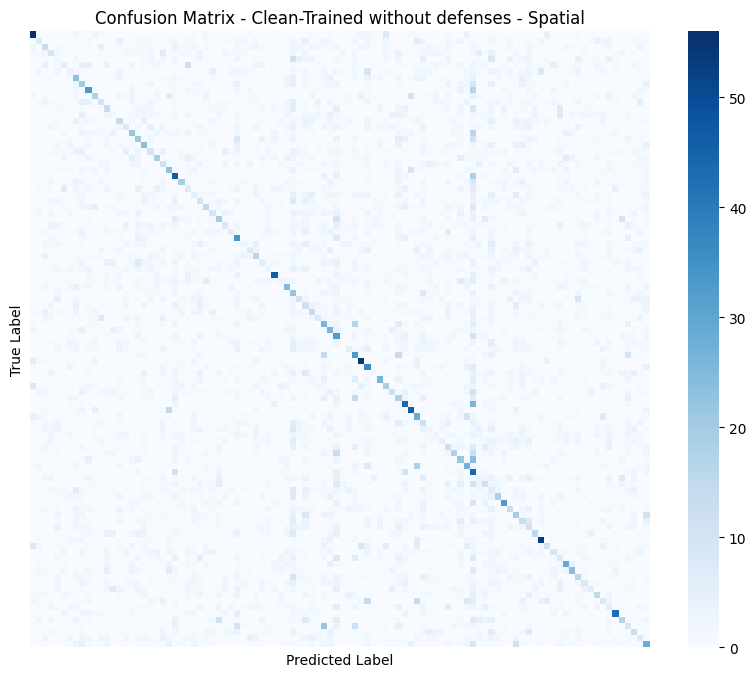

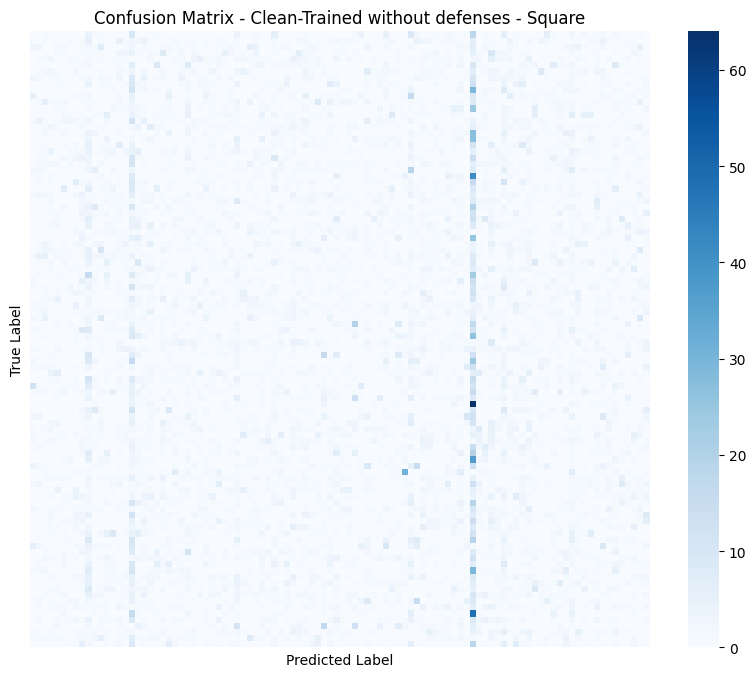

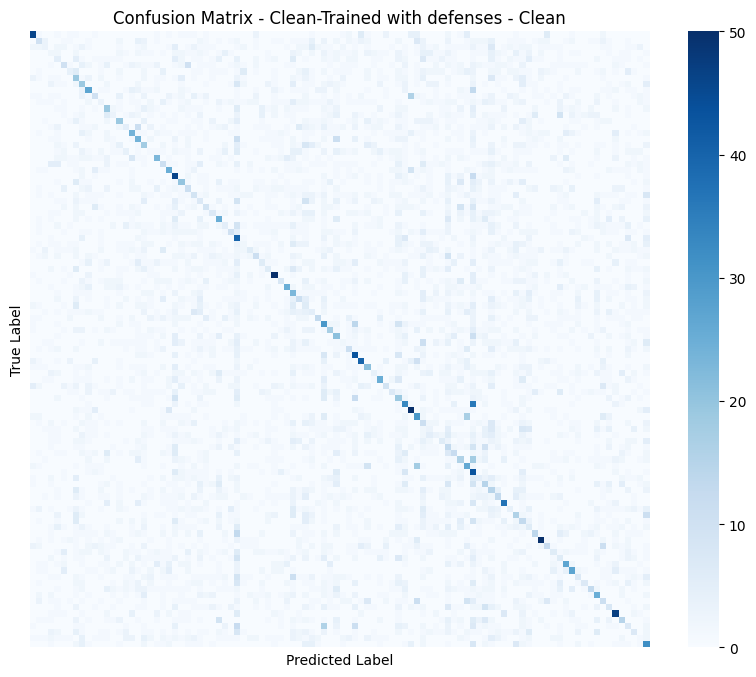

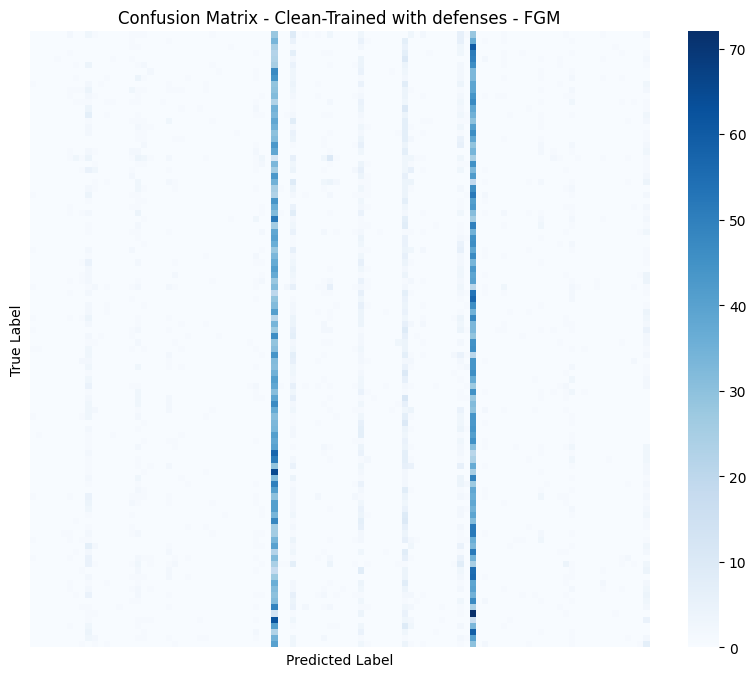

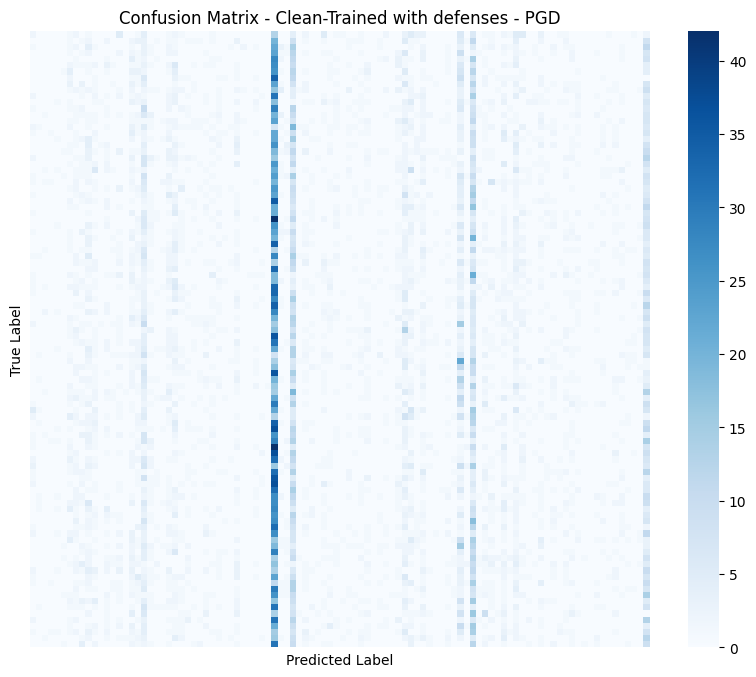

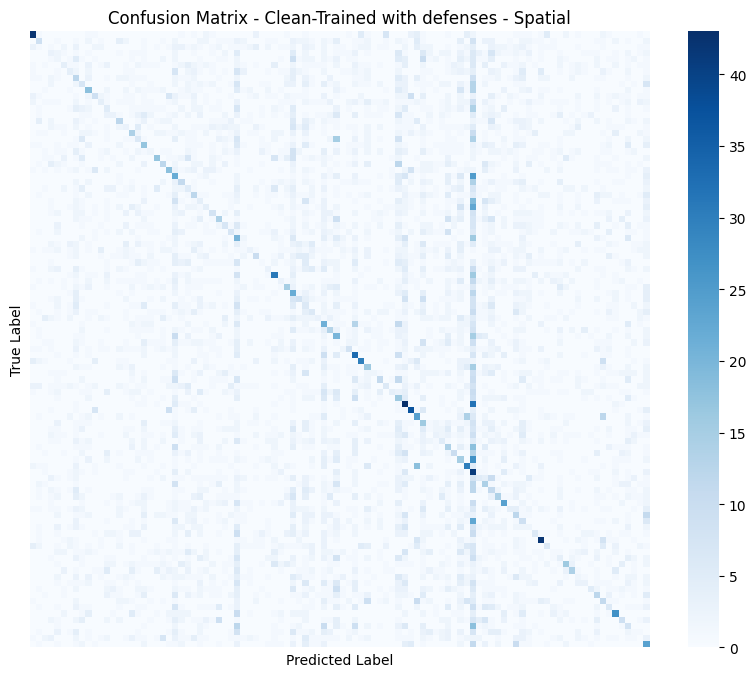

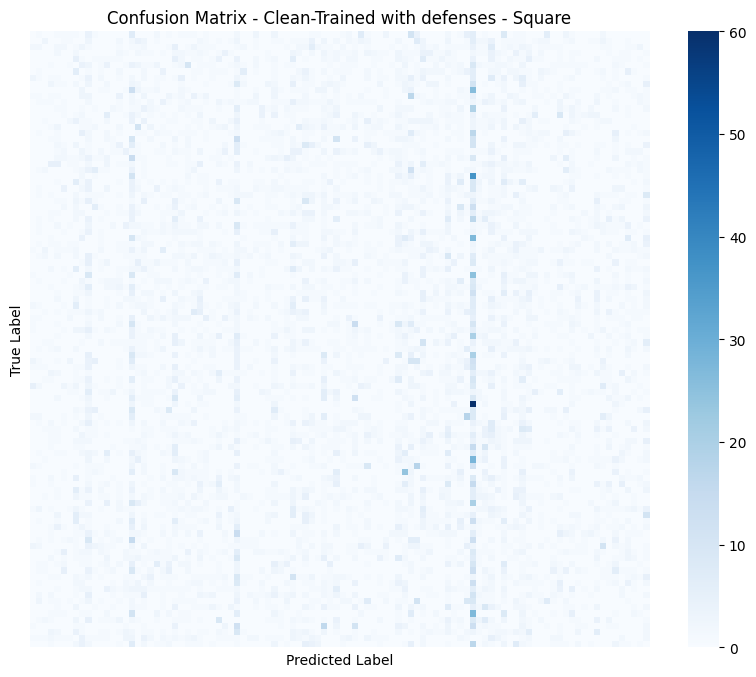

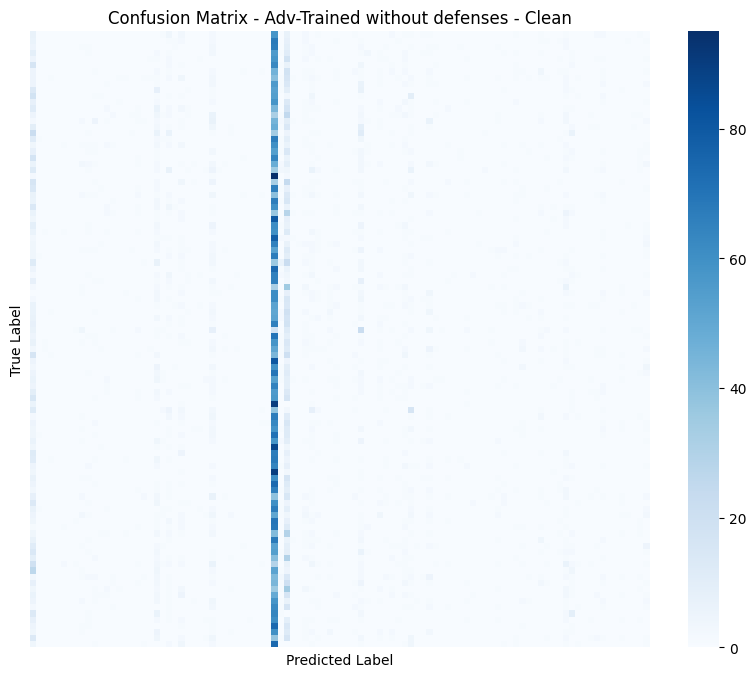

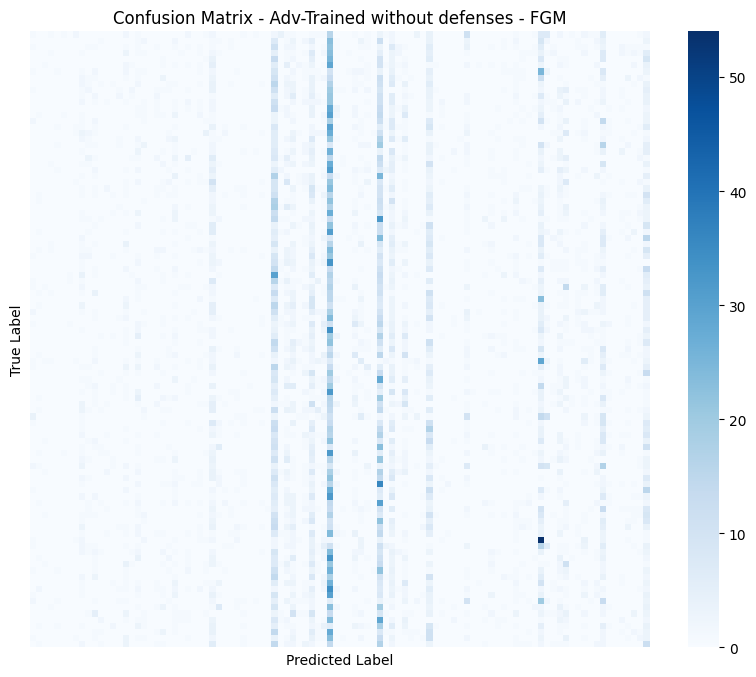

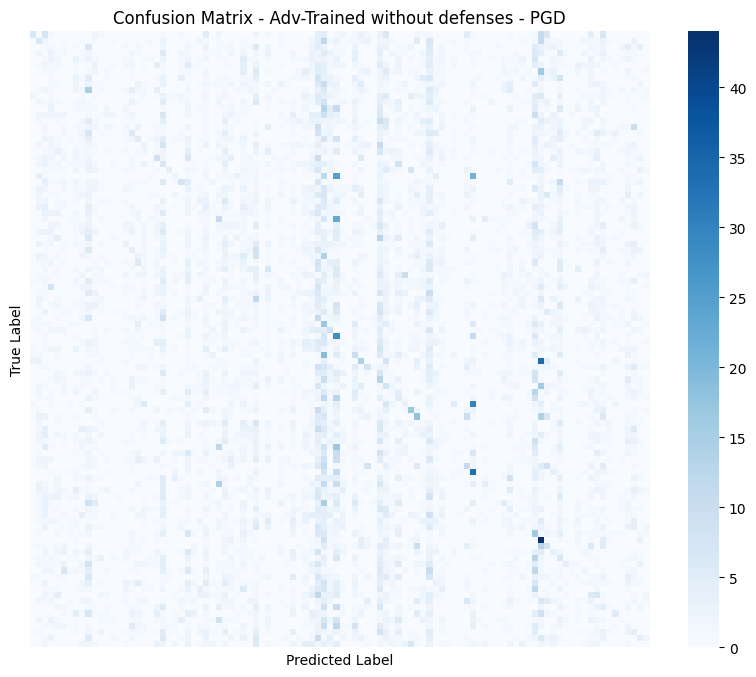

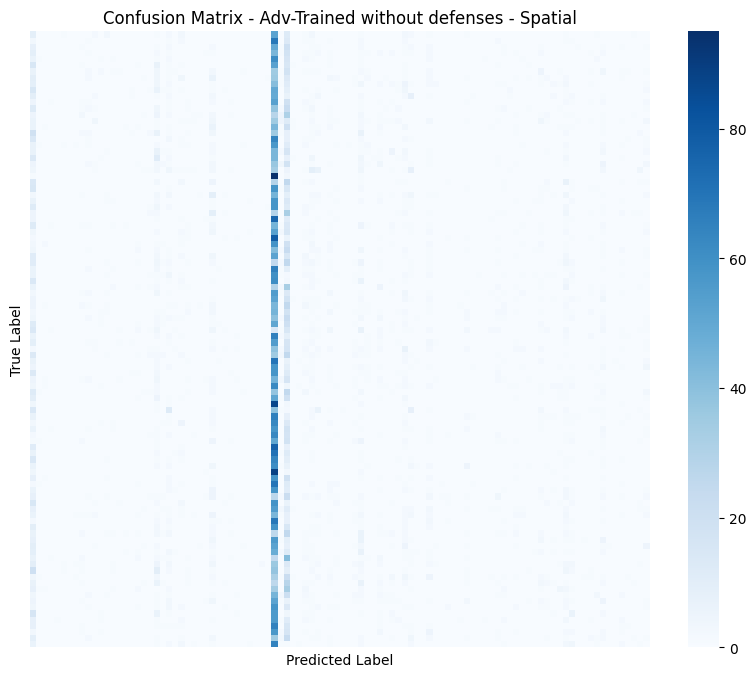

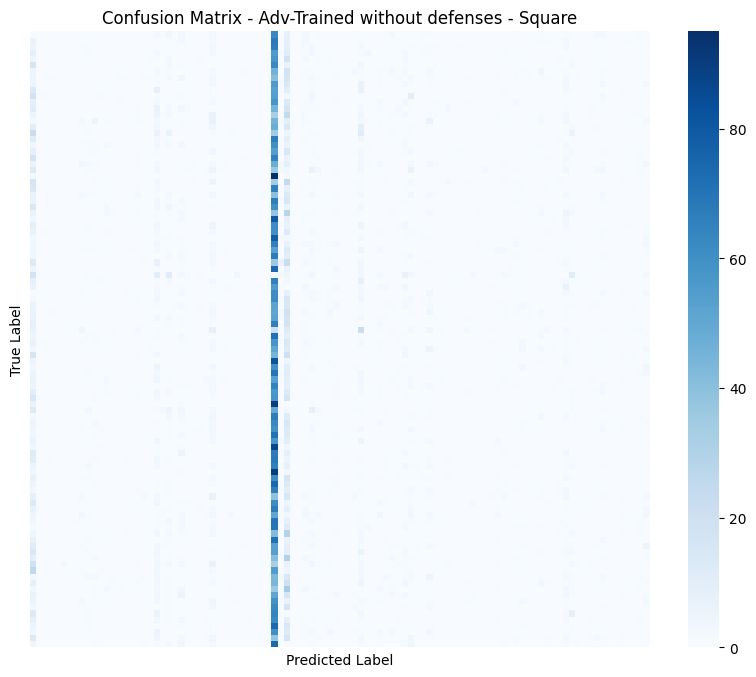

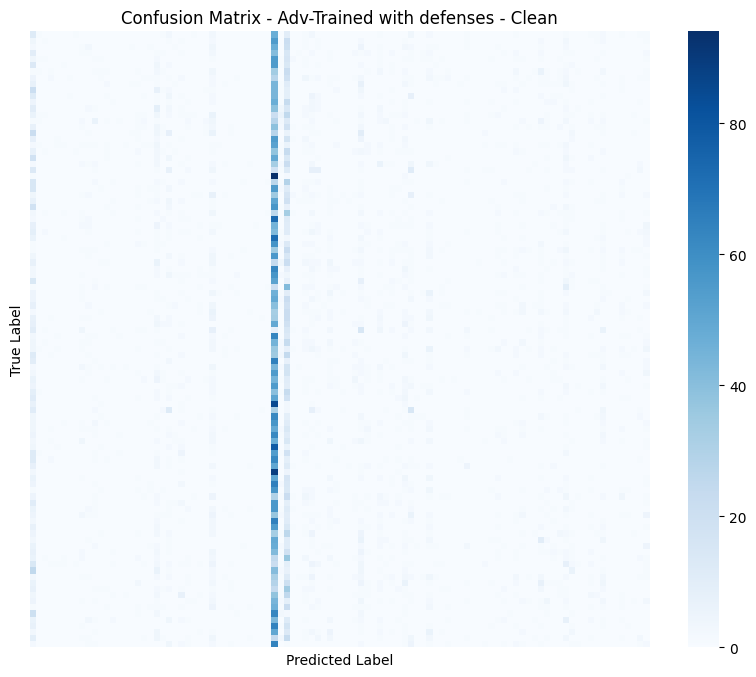

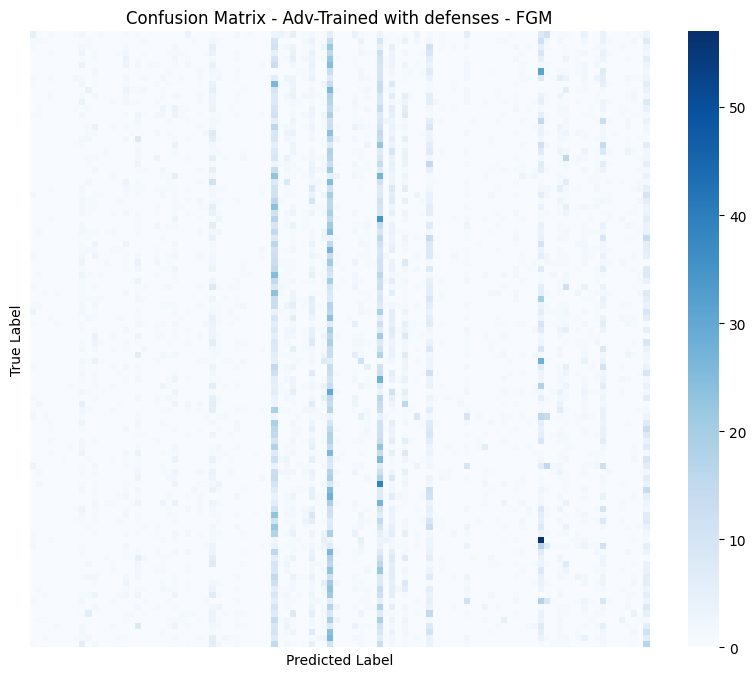

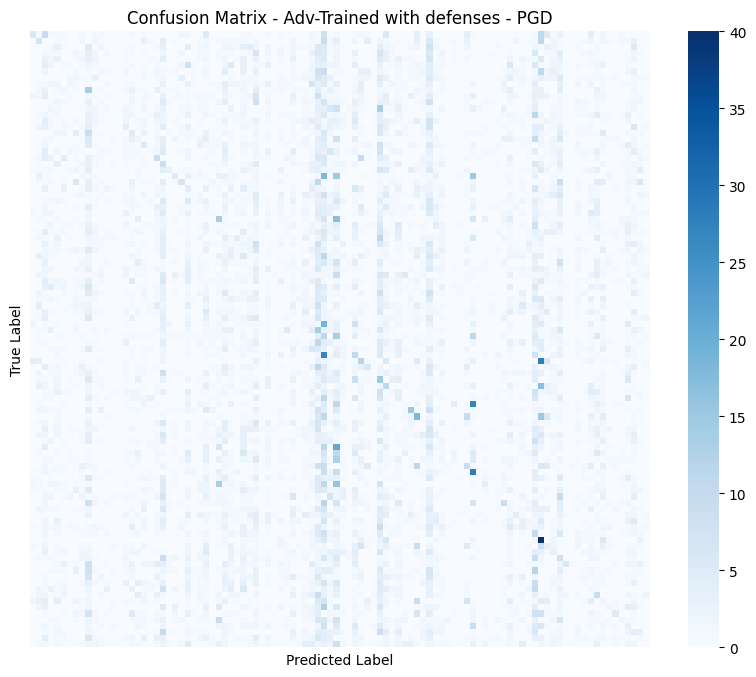

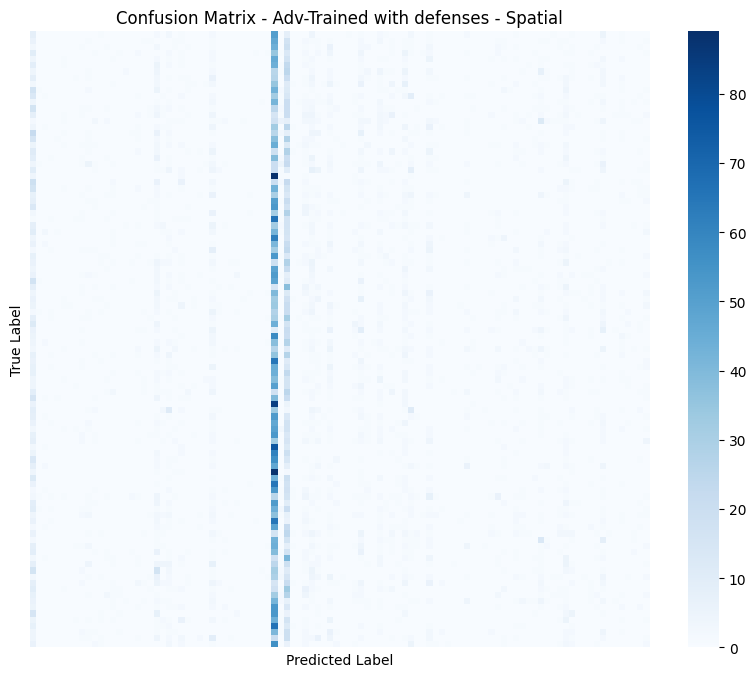

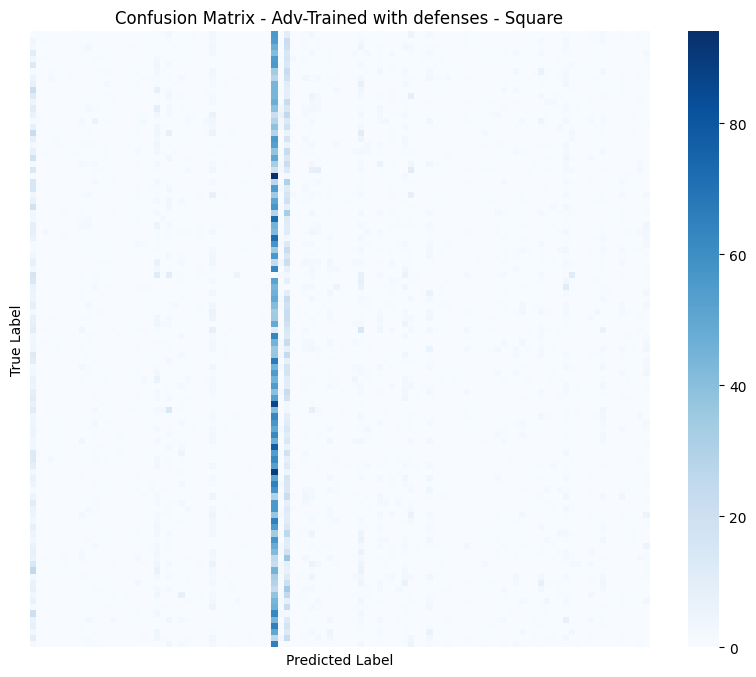

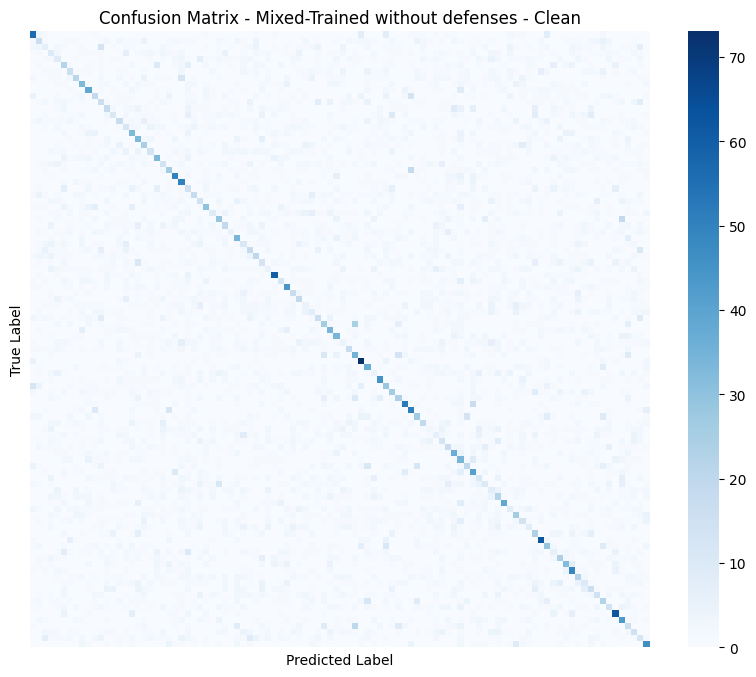

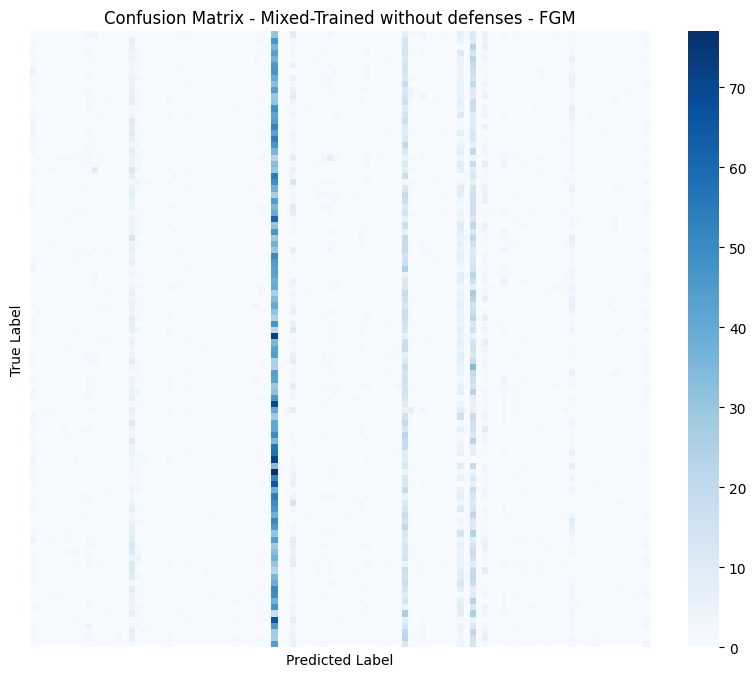

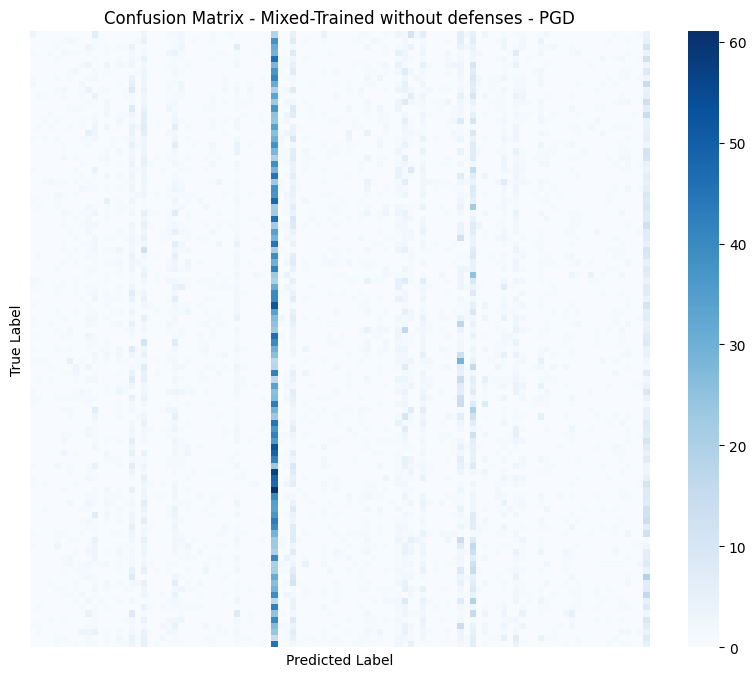

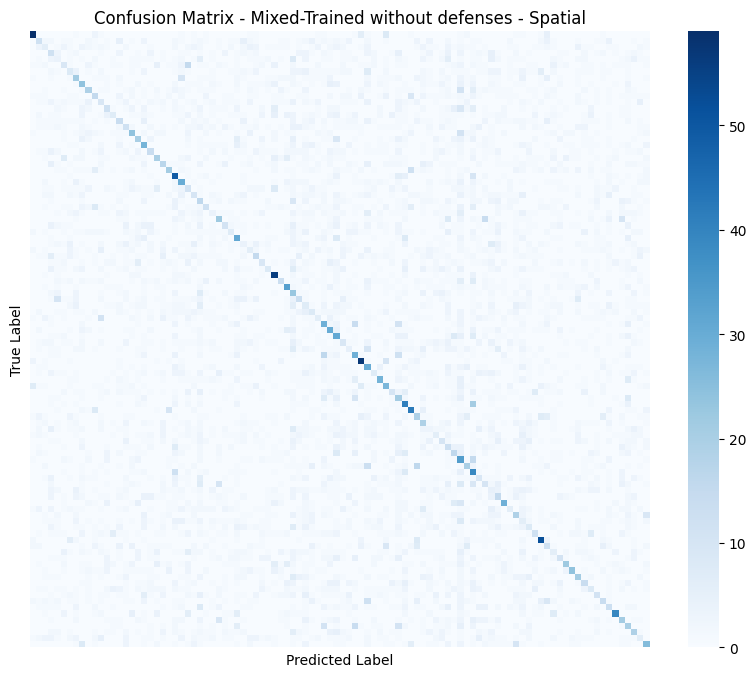

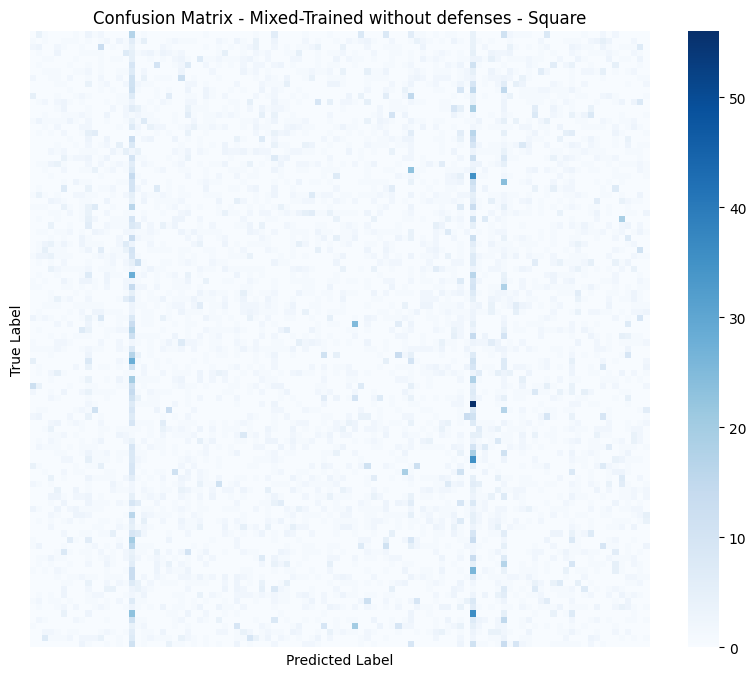

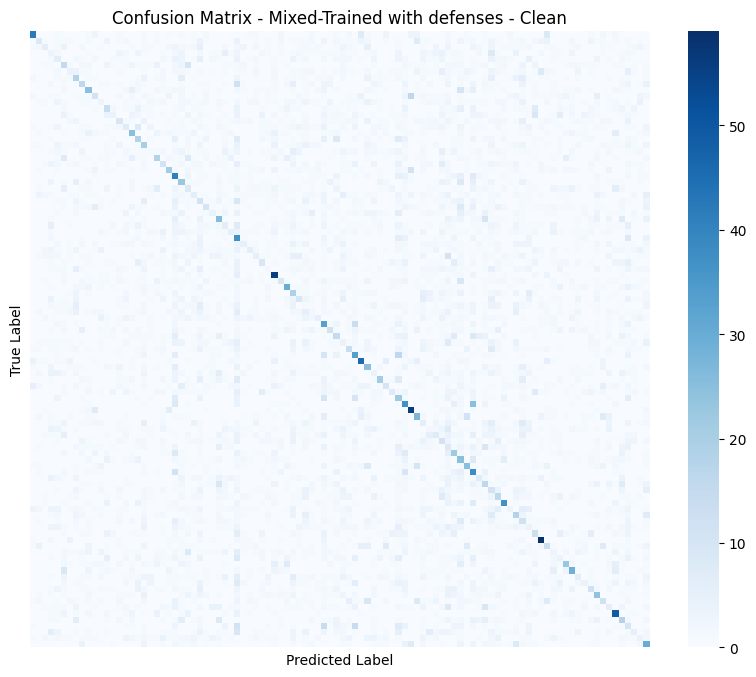

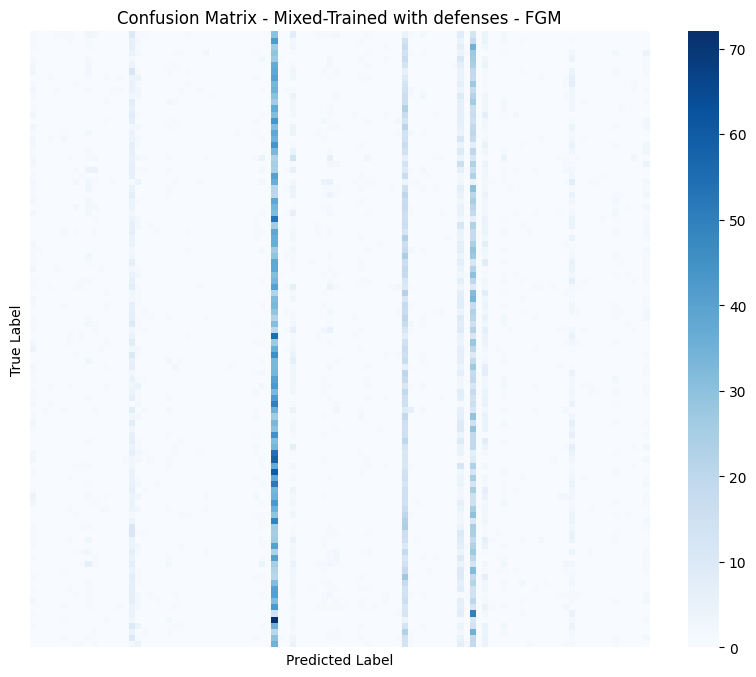

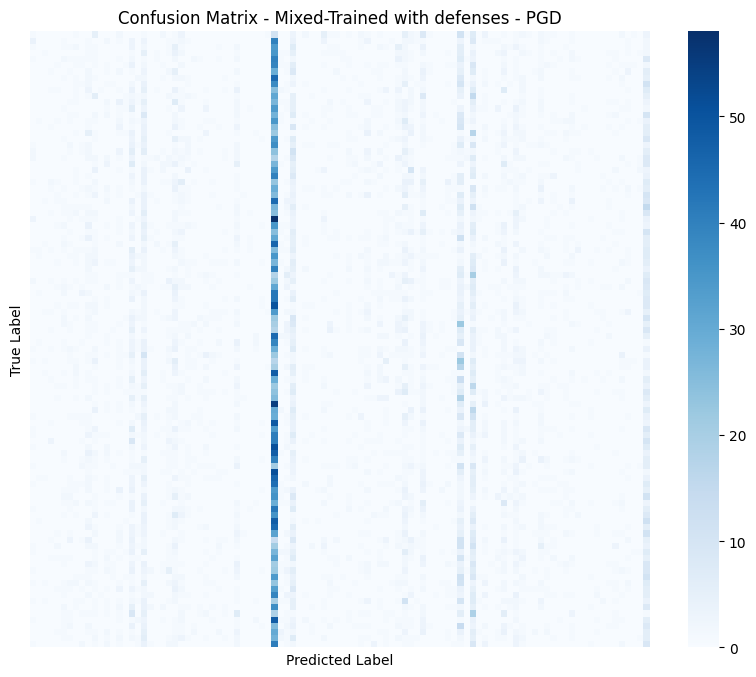

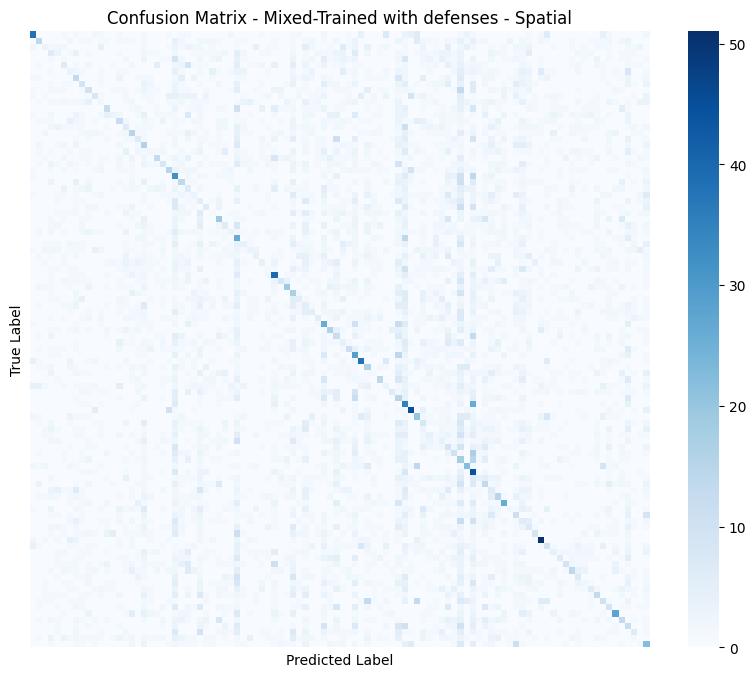

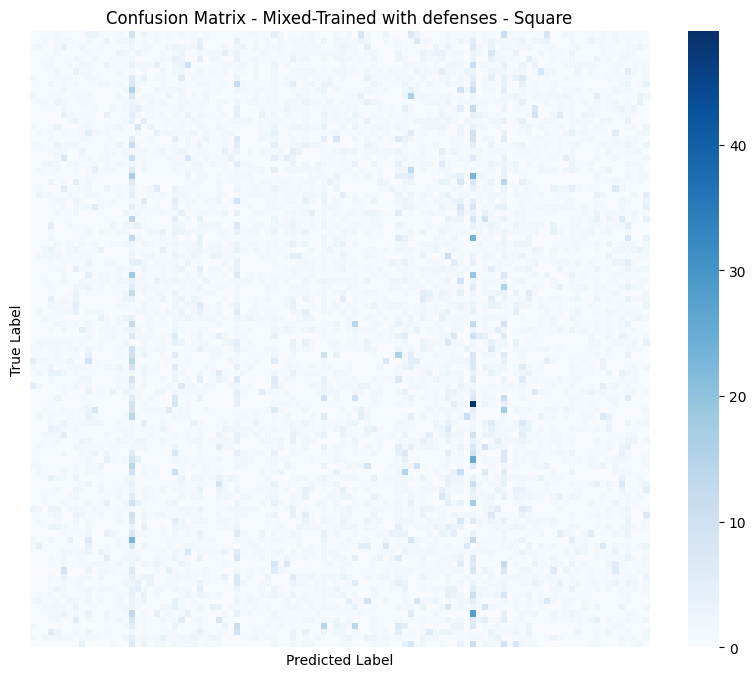

In [5]:
"""Evaluation of PGD, FSGM, spatial, and square attack efficacy with or without defenses"""

from io import BytesIO

from autoattack import AutoAttack
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import CIFAR100
import torchvision.utils as vutils
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import files

from easydict import EasyDict
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
)
from sklearn.preprocessing import label_binarize

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
import torchattacks

from ultralytics import YOLO
from ultralytics.models.yolo.model import ClassificationModel

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


class YOLOClassifierWrapper(nn.Module):
    def __init__(self, yolov8_model):
        super().__init__()
        self.model = yolov8_model

    def forward(self, x):
        out = self.model(x)
        if isinstance(out, tuple):
            out = out[0]  # Extract logits if it's a tuple
        return out


class Flags:
    eps = 0.3
    nb_epochs = 100
    inference_defenses = False


def overlay_label(image_tensor, class_idx):
    """Overlay small class name on a single image tensor."""
    image = to_pil_image(image_tensor.cpu())
    draw = ImageDraw.Draw(image)

    # Small font for 32x32 image
    try:
        font = ImageFont.truetype("arial.ttf", 8)
    except:
        font = ImageFont.load_default()

    label_text = cifar100_classes[class_idx]
    bbox = draw.textbbox((0, 0), label_text, font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

    # Draw background for visibility
    draw.rectangle([(0, 0), (text_width + 2, text_height + 2)], fill="black")
    draw.text((1, 1), label_text, fill="white", font=font)

    return to_tensor(image)


def save_attack_visuals(x_clean, x_attacks_dict, y_true, preds_dict, attack_names, filename_prefix):
    num_images = min(5, x_clean.size(0))
    images_to_plot = []

    # Clean images
    for i in range(num_images):
        label_idx = y_true[i].item()
        img = overlay_label(x_clean[i], label_idx)
        images_to_plot.append(img)

    # Adversarial images
    for name in attack_names:
        for i in range(num_images):
            pred_idx = preds_dict[name][i].item()
            img = overlay_label(x_attacks_dict[name][i], pred_idx)
            images_to_plot.append(img)

    grid = vutils.make_grid(images_to_plot, nrow=num_images, padding=2, normalize=True)
    plt.figure(figsize=(num_images * 2, (len(attack_names) + 1) * 2))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")

    filename = f"{filename_prefix}_attack_comparisons_labels.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

    files.download(filename)



def save_successful_attacks(x_clean, x_attacks_dict, y_true, preds_dict, attack_names, filename_prefix):
    for name in attack_names:
        for i in range(len(y_true)):
            if preds_dict['clean'][i] == y_true[i] and preds_dict[name][i] != y_true[i]:
                clean_label_idx = y_true[i].item()
                adv_pred_idx = preds_dict[name][i].item()

                clean_img = overlay_label(x_clean[i], clean_label_idx)
                adv_img = overlay_label(x_attacks_dict[name][i], adv_pred_idx)

                clean_filename = f"{filename_prefix}_{name}_clean_label.png"
                adv_filename = f"{filename_prefix}_{name}_adv_label.png"

                to_pil_image(clean_img.cpu()).save(clean_filename)
                to_pil_image(adv_img.cpu()).save(adv_filename)

                from google.colab import files
                files.download(clean_filename)
                files.download(adv_filename)

                print(f"Saved successful attack example for {name}")
                break


def jpeg_compression(x, quality=75):
    x = x.cpu()
    processed = []
    for img in x:
        pil_img = to_pil_image(img)
        buffer = BytesIO()
        pil_img.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        pil_img = Image.open(buffer)
        processed.append(to_tensor(pil_img))
    return torch.stack(processed).to(x.device)


# Bit-depth reduction
def reduce_bit_depth(x, bits=3):
    levels = 2 ** bits
    x = torch.round(x * levels) / levels
    return x


def spatial_attack(x, degrees=15, translate=(0.1, 0.1)):
    transform = T.RandomAffine(degrees=degrees, translate=translate)
    return torch.stack([transform(img) for img in x])


def evaluate_model(y_true, y_preds_dict, n_classes=100, label="Clean"):
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    all_reports = []

    for attack_name, y_pred in y_preds_dict.items():
        print(f"\n===== Evaluation: {attack_name} =====")

        # Classification report
        print(classification_report(y_true, y_pred, digits=4))
        report_dict = classification_report(y_true, y_pred, digits=4, output_dict=True)

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
        plt.title(f"Confusion Matrix - {attack_name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")

        # Flatten classification report and tag with attack name
        flat_metrics = {
            "attack": attack_name,
            "accuracy": report_dict["accuracy"],
            "macro avg_precision": report_dict["macro avg"]["precision"],
            "macro avg_recall": report_dict["macro avg"]["recall"],
            "macro avg_f1-score": report_dict["macro avg"]["f1-score"],
            "weighted avg_precision": report_dict["weighted avg"]["precision"],
            "weighted avg_recall": report_dict["weighted avg"]["recall"],
            "weighted avg_f1-score": report_dict["weighted avg"]["f1-score"],
        }
        all_reports.append(flat_metrics)

        # Save per-class report CSV (optional, as before)
        csv_filename = f"classification_report_{attack_name.replace(' ', '_')}.csv"
        pd.DataFrame(report_dict).transpose().to_csv(csv_filename)
        files.download(csv_filename)

        # AUC-ROC (macro average)
        try:
            y_pred_bin = label_binarize(y_pred, classes=list(range(n_classes)))
            auc_score = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
            print(f"AUC-ROC (macro, OVR): {auc_score:.4f}")
        except ValueError as e:
            print("AUC-ROC could not be computed:", e)


def evaluate(model_name, model_path, use_defenses):
    loss_fn = nn.CrossEntropyLoss()
    net = torch.load(model_path)
    net.to(device).float()
    net.eval()

    square = torchattacks.Square(net, eps=FLAGS.eps)
    #autoattack = AutoAttack(net, norm='Linf', eps=FLAGS.eps, version='standard')
    #autoattack.attacks_to_run = ['apgd-ce', 'apgd-dlr']

    if use_defenses:
        print(f"\nEvaluating {model_name} with inference-time defenses")
    else:
        print(f"\nEvaluating {model_name} without inference-time defenses")

    report = EasyDict(
        nb_test=0,
        correct=0,
        correct_fgm=0,
        correct_pgd=0,
        correct_spatial=0,
        correct_square=0,
        #correct_auto=0
        )

    all_y_true, all_y_pred_clean = [], []
    all_y_pred_fgm, all_y_pred_pgd = [], []
    all_y_pred_square, all_y_pred_spatial = [], []
    #all_y_pred_auto = []

    for x, y in data.test:
        """# Require logits and full batches
        if x.size(0) == 128:
            x_auto = autoattack.run_standard_evaluation(x, y, bs=128)
            _, y_pred_auto = net(x_auto).max(1)
        else:
            # Fallback if not batch size 128
            x_auto = torch.zeros_like(x)
            y_pred_auto = torch.zeros_like(y)
        """

        if use_defenses:
            x = jpeg_compression(x)
            x = reduce_bit_depth(x)

        x, y = x.to(device), y.to(device)

        x_fgm = fast_gradient_method(net, x, FLAGS.eps, np.inf)
        x_pgd = projected_gradient_descent(net, x, FLAGS.eps, 0.01, 40, np.inf)
        x_square = square(x, y)
        x_spatial = spatial_attack(x)

        _, y_pred = net(x).max(1)
        _, y_pred_fgm = net(x_fgm).max(1)
        _, y_pred_pgd = net(x_pgd).max(1)
        _, y_pred_spatial = net(x_spatial).max(1)
        _, y_pred_square = net(x_square).max(1)

        all_y_true.extend(y.cpu().numpy())
        all_y_pred_clean.extend(y_pred.cpu().numpy())
        all_y_pred_fgm.extend(y_pred_fgm.cpu().numpy())
        all_y_pred_pgd.extend(y_pred_pgd.cpu().numpy())
        all_y_pred_spatial.extend(y_pred_spatial.cpu().numpy())
        all_y_pred_square.extend(y_pred_square.cpu().numpy())
        #all_y_pred_auto.extend(y_pred_auto.cpu().numpy())

        if report.nb_test == 0:
            # Save visualizations only for the first batch
            preds_dict = {
                "clean": y_pred,
                "FGM": y_pred_fgm,
                "PGD": y_pred_pgd,
                "Spatial": y_pred_spatial,
                "Square": y_pred_square,
                #"Auto": y_pred_auto,
            }

            x_attacks_dict = {
                "FGM": x_fgm,
                "PGD": x_pgd,
                "Spatial": x_spatial,
                "Square": x_square,
                #"Auto": x_auto,
            }

            save_attack_visuals(x, x_attacks_dict, y, preds_dict, attack_names=["FGM", "PGD", "Spatial", "Square"], filename_prefix="comparison")
            save_successful_attacks(x, x_attacks_dict, y, preds_dict, attack_names=["FGM", "PGD", "Spatial", "Square"], filename_prefix="success")

        report.nb_test += y.size(0)
        report.correct += y_pred.eq(y).sum().item()
        report.correct_fgm += y_pred_fgm.eq(y).sum().item()
        report.correct_pgd += y_pred_pgd.eq(y).sum().item()
        report.correct_spatial += y_pred_spatial.eq(y).sum().item()
        report.correct_square += y_pred_square.eq(y).sum().item()
        #report.correct_auto += y_pred_auto.eq(y).sum().item()

    base = f"{model_name} {'with defenses' if use_defenses else 'without defenses'}"
    print(f"{base} accuracy on clean examples: {report.correct / report.nb_test * 100.0:.2f}%")
    print(f"{base} accuracy on FGM: {report.correct_fgm / report.nb_test * 100.0:.2f}%")
    print(f"{base} accuracy on PGD: {report.correct_pgd / report.nb_test * 100.0:.2f}%")
    print(f"{base} accuracy on Spatial: {report.correct_spatial / report.nb_test * 100.0:.2f}%")
    print(f"{base} accuracy on Square: {report.correct_square / report.nb_test * 100.0:.2f}%")
    #print(f"{base} accuracy on Auto: {report.correct_auto / report.nb_test * 100.0:.2f}%")

    evaluate_model(
        y_true=all_y_true,
        y_preds_dict={
            f"{base} - Clean": all_y_pred_clean,
            f"{base} - FGM": all_y_pred_fgm,
            f"{base} - PGD": all_y_pred_pgd,
            f"{base} - Spatial": all_y_pred_spatial,
            f"{base} - Square": all_y_pred_square,
            #f"{base} - Auto": all_y_pred_auto,
        },
        n_classes=100
    )


FLAGS = Flags

cifar100_classes = CIFAR100(root="/tmp/data", train=False, download=True).classes

models = {
    "Clean-Trained": "/content/models/clean-trained.pt",
    "Adv-Trained": "/content/models/adv-trained.pt",
    "Mixed-Trained": "/content/models/mixed-trained.pt",
}

# Input data
train_transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()]
)
test_transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()]
)
train_dataset = torchvision.datasets.CIFAR100(
    root="/tmp/data", train=True, transform=train_transforms, download=True
)
test_dataset = torchvision.datasets.CIFAR100(
    root="/tmp/data", train=False, transform=test_transforms, download=True
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2
)

data = EasyDict(train=train_loader, test=test_loader)

# Use GPU
device = "cuda"

for model_name, model in models.items():
    for use_defenses in [False, True]:
        evaluate(model_name, model, use_defenses)
